### Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from imageio import imread

sns.set_theme(style="darkgrid")



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading Images
- Class 1 is the True class - images of ships that are centered in the satellite image
- Class 0 is the False class - images of random land cover that do not include ships or partially include ships

In [3]:
# Path to dataset
IMG_DIR = '/content/drive/MyDrive/shipsnet'
class1 = []
class0 = []
for file in os.listdir(IMG_DIR):
    loaded_img = imread(os.path.join(IMG_DIR, file))
    if file[0] == '0':
        class0.append(loaded_img)
    else:
        class1.append(loaded_img)
class1 = np.array(class1)
class0 = np.array(class0)

print(f"Class 1 shape: {class1.shape}")
print(f"Class 0 shape: {class0.shape}")

<ipython-input-3-de60d8305d1d>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  loaded_img = imread(os.path.join(IMG_DIR, file))


Class 1 shape: (1000, 80, 80, 3)
Class 0 shape: (3000, 80, 80, 3)


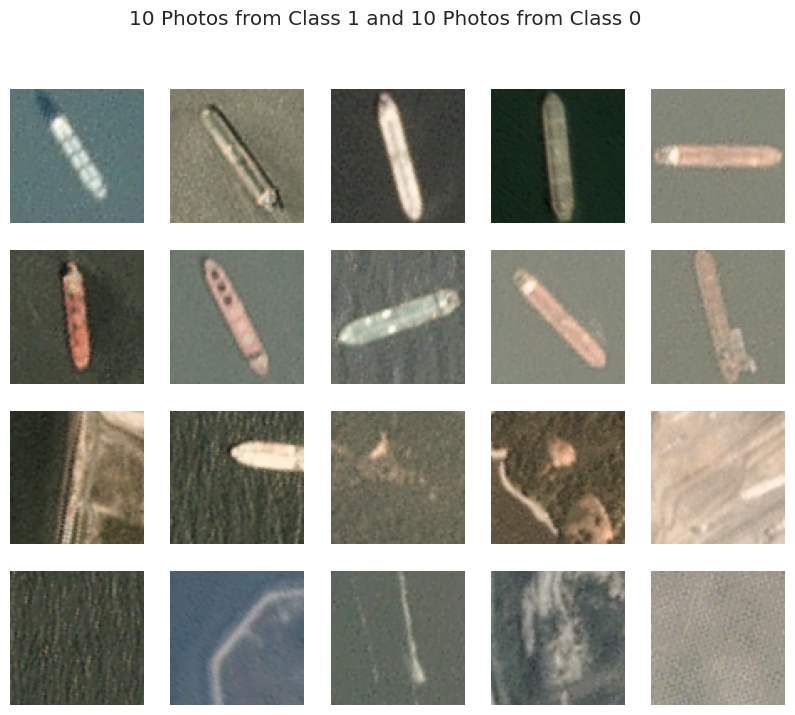

In [4]:
# TODO: clean up plot
np.random.seed = 888

fig, axs = plt.subplots(4, 5, figsize=(10, 8))
class1_sample = np.random.choice(range(len(class1)), 10, replace=False)
class0_sample = np.random.choice(range(len(class0)), 10, replace=False)

for idx, img in enumerate(class1[class1_sample]):
    axs[idx % 2][idx % 5].imshow(img)
    axs[idx % 2][idx % 5].axis('off')

for idx, img in enumerate(class0[class0_sample]):
    axs[idx % 2 + 2][idx % 5].imshow(img)
    axs[idx % 2 + 2][idx % 5].axis('off')
plt.suptitle("10 Photos from Class 1 and 10 Photos from Class 0")
plt.show()

### General Thoughts
- Since orientation of ships varies significantly, a model that detects edges (CNNs) is likely to be a lot more performant than, e.g. logistic regression
- Noise in images - may benefit from some kind of noise reduction technique as a part of the model prediction pipeline?
    - Median filter (also called median blur) may be helpful @ noise reduction
        - need to determine window size
    - How would we implement?
        - Need to create a wrapper if we wanted to apply it @ inference for sklearn?
        - Can add as layer in TF model
- Images appear to be at differing contrasts, potentially due to cloud cover, time of day, air pollution, etc.
    - Image augmentation that varies brightness and contrast will probably be really helpful
    - Would varying saturation help?
- Images feature ships in different orientations
    - Image augmentation that reorients images (random rotate? tf.image.rot90?) will probably be helpful
- Other geometric image augmentation techniques like shearing, rotating, cropping, etc. don't seem applicable since our True class is photos where the ship is centered (e.g. if we crop an image w/ class 1, we'd end up with a ship that's no longer centered and may be cut off which should actually be interpreted as class 0)

## Experimenting using different Learning Rates in order to arrive at the model with best validating accuracy

Training model with learning rate: 0.001
Training model with learning rate: 0.0001
Training model with learning rate: 1e-05


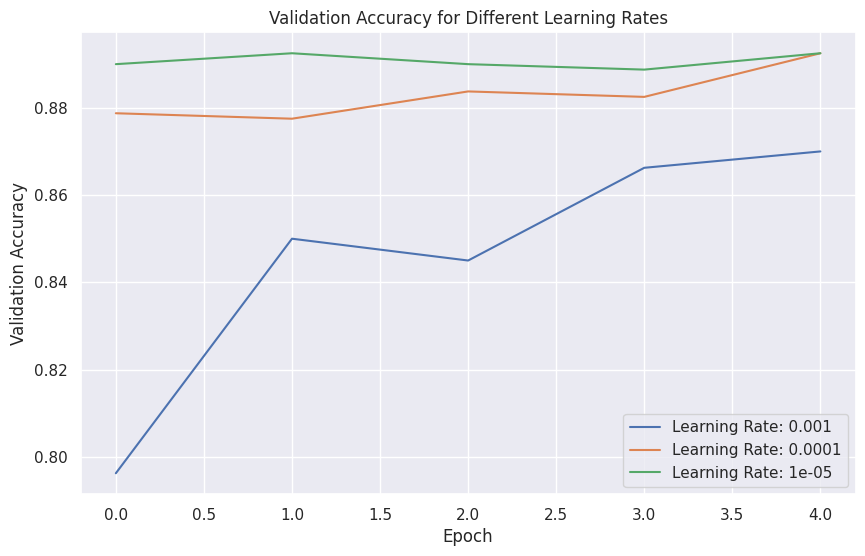

In [7]:
import numpy as np
import os
from imageio import imread
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt

# Model training
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(80, 80, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Performing Data augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,     # Rondomly rotating images
    width_shift_range=0.2,     # Shifting Image width to adjust image edges
    brightness_range=[0.7, 1.3],  # Randomly adjusting brightness
    height_shift_range=0.2,  # Shifting Image height to adjust image edges
    zca_epsilon=[0.8, 1.2],   # Randomly adjusting contrast
    shear_range=0.2,          # Randomly adjusting shear so model can learn tilted images
    zoom_range=0.2,           # Randomly zooming images
    horizontal_flip=True,     # Randomly fliping images
    fill_mode='nearest')

# Function to apply median filtering to images
def apply_median_filter(image, window_size=3): # Window size is set to 3.
    filtered_image = median_filter(image, size=window_size)
    return filtered_image

# Applying median filtering to images
class1_filtered = np.array([apply_median_filter(img) for img in class1])
class0_filtered = np.array([apply_median_filter(img) for img in class0])

# Concatenating filtered images
X = np.concatenate((class1_filtered, class0_filtered), axis=0)
y = np.concatenate((np.ones(class1.shape[0]), np.zeros(class0.shape[0])), axis=0)


# Split the dataset into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Normalizing pixel values to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

datagen.fit(X_train)

# Define different learning rates to experiment with
learning_rates = [0.001, 0.0001, 0.00001]

# Train the model with different learning rates
history_list = []
for learning_rate in learning_rates:
    print(f"Training model with learning rate: {learning_rate}")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                        steps_per_epoch=len(X_train) / 32, epochs=5, validation_data=(X_test, y_test),
                        verbose=0)
    history_list.append(history)

# Plot training history for each learning rate
plt.figure(figsize=(10, 6))
for i, learning_rate in enumerate(learning_rates):
    plt.plot(history_list[i].history['val_accuracy'], label=f'Learning Rate: {learning_rate}')

plt.title('Validation Accuracy for Different Learning Rates')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

## Developing Model with 5 Epochs and 0.00001 learning rate

Epoch 1/5
75/75 [==============================] - 34s 434ms/step - loss: 0.5984 - accuracy: 0.7421 - val_loss: 0.5585 - val_accuracy: 0.7513
Epoch 2/5
75/75 [==============================] - 35s 469ms/step - loss: 0.5423 - accuracy: 0.7533 - val_loss: 0.5341 - val_accuracy: 0.7513
Epoch 3/5
75/75 [==============================] - 34s 454ms/step - loss: 0.5243 - accuracy: 0.7538 - val_loss: 0.4972 - val_accuracy: 0.7575
Epoch 4/5
75/75 [==============================] - 33s 438ms/step - loss: 0.4993 - accuracy: 0.7663 - val_loss: 0.4554 - val_accuracy: 0.7825
Epoch 5/5
25/25 [==============================] - 3s 105ms/step - loss: 0.4370 - accuracy: 0.7950
Test Accuracy: 0.7950000166893005


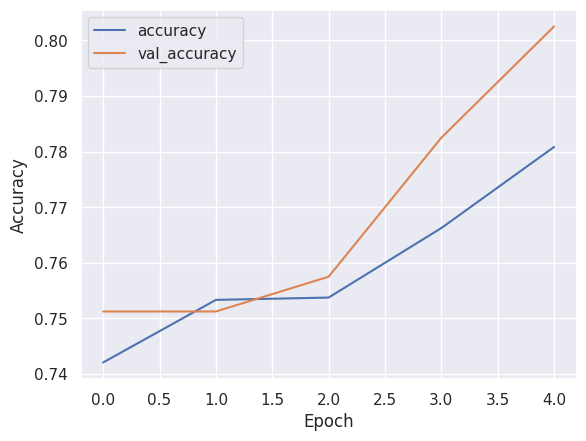

In [18]:


# Define the CNN model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(80, 80, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Data augmentation to improve generalization
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

datagen.fit(X_train)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=5, validation_data=(X_val, y_val))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


The model appears to be performing really well as testing accuracy is higher that training accuracy. The data augmentation process helped reduce generalization.

## Developing Model using 10 epochs and 0.0001 learning rate

Epoch 1/5
75/75 [==============================] - 37s 467ms/step - loss: 0.5436 - accuracy: 0.7500 - val_loss: 0.4470 - val_accuracy: 0.7738
Epoch 2/5
75/75 [==============================] - 35s 473ms/step - loss: 0.4472 - accuracy: 0.7908 - val_loss: 0.3468 - val_accuracy: 0.8525
Epoch 3/5
75/75 [==============================] - 35s 466ms/step - loss: 0.4073 - accuracy: 0.8133 - val_loss: 0.3075 - val_accuracy: 0.8963
Epoch 4/5
75/75 [==============================] - 34s 449ms/step - loss: 0.3691 - accuracy: 0.8342 - val_loss: 0.2499 - val_accuracy: 0.9062
Epoch 5/5
25/25 [==============================] - 2s 85ms/step - loss: 0.2689 - accuracy: 0.8888
Test Accuracy: 0.8887500166893005


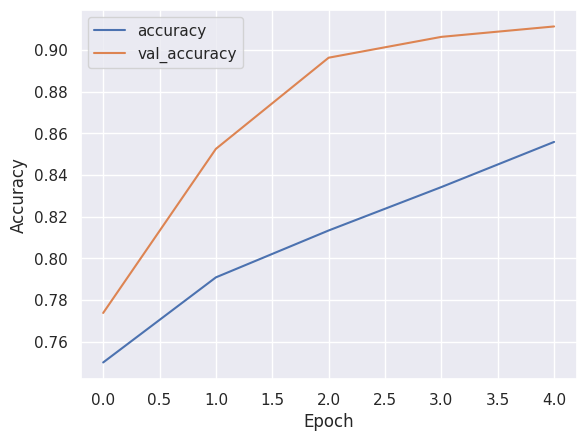

In [19]:
# Define the CNN model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(80, 80, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Data augmentation to improve generalization
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

datagen.fit(X_train)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=5, validation_data=(X_val, y_val))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

# Plot training history

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The model with 0.0001 learninig rate and 5 epoch performs even better than the model with 0.00001 learning rate and 5 epochs, with can use this model as our best model.

In [20]:
def make_predictions(model, data):

    # Making predictions
    predictions = model.predict(data)

    # Converting predictions to binary labels (0 or 1)
    predictions = (predictions > 0.5).astype(int)

    return predictions


## Confusion Matrix

25/25 [==============================] - 3s 97ms/step


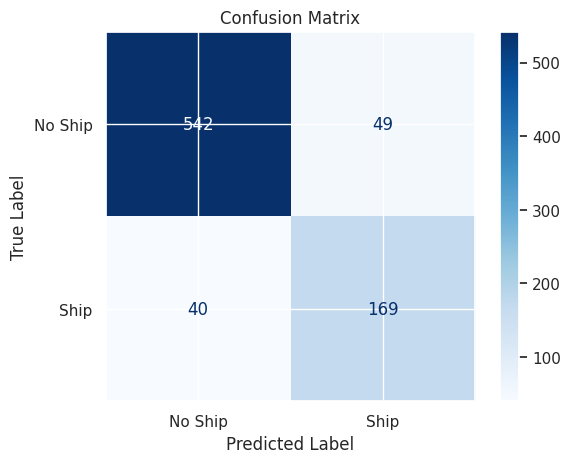

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = make_predictions(model,X_test)
# Generate confusion matrix
cm = confusion_matrix(y_test, predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Ship', 'Ship'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [12]:
X_test.shape

(800, 80, 80, 3)

In [13]:
X_train.shape

(2400, 80, 80, 3)

In [14]:
X_val.shape

(800, 80, 80, 3)